<a href="https://colab.research.google.com/github/xyaoaf/UrbanTreeStudywithLidar/blob/main/230105_Xihan_BandsCorrelation(pixel).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 23.8 MB/s eta 0:00:00


# New Section

In [ ]:
import os, glob
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [ ]:
def open_data(img_path):
    with rasterio.open(img_path, 'r') as src:
        img = src.read(1)
        meta = src.meta
    return img, meta

def open_ps(img_path):
    with rasterio.open(img_path, 'r') as src:
        b1,b2,b3,b4 = src.read([3,2,1,4]) #blue
        meta = src.meta
    img = np.dstack((b1,b2,b3,b4)) # This is a 4band image in b,g,r,n
    
    return img, meta

def open_s2(img_path):
    with rasterio.open(img_path, 'r') as src:
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10 = src.read([1-10]) #blue
        meta = src.meta
    img = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10)) # This is a 4band image in b,g,r,n
    
    return img, meta

def clip(img, percentile):
    out = np.zeros_like(img.shape[2])
    for i in range(img.shape[2]):
        a = 0 
        b = 255 
        c = np.percentile(img[:,:,i], percentile)
        d = np.percentile(img[:,:,i], 100 - percentile)        
        t = a + (img[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        img[:,:,i] =t
    rgb_out = img.astype(np.uint8)   
    return rgb_out

# PS Scaling (specific for filenaming)
def ps_scaling(image_file):

    # Set image geotiff name
    img_path = image_file.split('/')[-1]
    
    # Open 4-band PS imagery
    with rasterio.open(image_file) as src:
        band_blue, band_green, band_red, band_nir = (src.read(k) for k in (1, 2, 3, 4))
    
    # Open xml for coefficients
    xmldoc = minidom.parse(image_file.split('SR_clip.tif')[0]+str('Analytic_metadata_clip.xml'))
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)

    # Multiply by corresponding coefficients
    band_blue = band_blue * coeffs[1]
    band_green = band_green * coeffs[2]
    band_red = band_red * coeffs[3]
    band_nir = band_nir * coeffs[4]
    
    ps_img = np.stack((band_blue, band_green, band_red, band_nir))
    
    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        compress='lzw',
        count = ps_img.shape[0])

    # Create the file
    with rasterio.open(img_path.split('.')[0]+'_scaled.tif', 'w', **kwargs) as dst:
            dst.write(ps_img)
            print("Image saved : ", img_path.split('.')[0]+'_sr_scaled.tif')
            

def minmax(img):
    a = ( img - np.nanmin(img) ) / ( np.nanmin(img) + np.nanmax(img) )
    return a       
            
from rasterio.merge import merge
def mosaic(output_file, mosaic_list):

    # Grab a copy of our source metadata, using img1
    with rasterio.open(mosaic_list[0]) as src:
        meta = src.meta

    (mosaic, transform) = rasterio.merge.merge(mosaic_list)
    
    # Update the original metadata to reflect the specifics of our new mosaic
    meta.update({"transform": transform,
                 "height":mosaic.shape[1],
                 "width":mosaic.shape[2],
                 "compress":"lzw"})

    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(mosaic)


def spectral_index(blue, green, red, nir):
    ndvi = (nir-red) / (nir + red)
    savi = (nir-red) / ((nir + red)* 1.5)
    msavi = (2*nir + 1 - (((2*nir)+1)**2 - 8*(nir-red))**0.5)/2
    evi = (2.5 * (nir - red)) / (nir + (2.4*red) + 1)
    gndvi = (nir - green) / (nir + green)
    vari = (green-red) / (green+red-blue)
    gci = (nir/green) - 1

    return ndvi, savi, msavi, evi, gndvi, vari, gci

# Input directories and paths

In [ ]:
# # Set basepath and shift to base path directory
# BASE_PATH = '/content/drive/MyDrive/XihanYAO_GISDataShare' ### !!! CHANGE ME
# os.chdir(BASE_PATH)

# # Define file paths
# shp_path = os.path.join(BASE_PATH, '/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190805TractStack.tif')  # Census tract shapefile path
# kernel_path = os.path.join('')
# img_path = os.path.join(BASE_PATH, '/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190805ImageStack.tif')  # Image paths
# svi_path = os.path.join(BASE_PATH, '/230103_SocialVulnerabilityIndex/SVI2020_ugb_raster.tif')

img_path='/content/drive/MyDrive/XihanYAO_GISDataShare/230102_CityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI,VegUmixing,NDBI,NDWI)/landsatImageStack2019-08-05_230109.tif'
building_path= '/content/drive/MyDrive/XihanYAO_GISDataShare/230109_buildingDensity/building_density.tif'
smooth_path= '/content/drive/MyDrive/XihanYAO_GISDataShare/230102_CityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI,VegUmixing,NDBI,NDWI)/landsatImageStackSmooth2019-08-05_230109.tif'
naip_path= '/content/drive/MyDrive/XihanYAO_GISDataShare/230102_CityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI,VegUmixing,NDBI,NDWI)/naip2020ImageStack.tif'
shp_path='/content/drive/MyDrive/XihanYAO_GISDataShare/230102_CityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI,VegUmixing,NDBI,NDWI)/landsatTractStack2019-08-05.tif'
# svi_path='/content/drive/MyDrive/XihanYAO_GISDataShare/230103_SocialVulnerabilityIndex/SVI_Masked_fromGEE.tif'

In [ ]:
# # Open and load raster dataset
# with rasterio.open(img_path, 'r') as src:
#   img = src.read(1) # Read image
#   img_meta = src.meta.copy() # Save the metadata in memory
#   print(img_meta)
#   print("this gives you the number of bands in the image: ", img_meta['count'])

# with rasterio.open(naip_path, 'r') as src:
#   naip = src.read(1) # Read image
#   naip_meta = src.meta.copy() # Save the metadata in memory
#   print(naip_meta)
#   print("this gives you the number of bands in the image: ", naip_meta['count'])
  
# with rasterio.open(shp_path, 'r') as src:
#   shp = src.read(1) # Read image
#   shp_meta = src.meta.copy() # Save the metadata in memory
#   print(shp_meta)
#   print("this gives you the number of bands in the image: ", shp_meta['count'])

# with rasterio.open(svi_path, 'r') as src:
#   svi = src.read(1) # Read image
#   svi_meta = src.meta.copy() # Save the metadata in memory
#   print(svi_meta)
#   print("this gives you the number of bands in the image: ", svi_meta['count'])
# # Input Images
# os.chdir(img_path)
# img_files = sorted(glob.glob(os.path.join(img_path, '*.tif')))

# img_files

# # Define images
# lst = 'LST.tif'
# ndvi = 'NDVI.tif'

# # Load using "Rasterio" and the driver
# # https://rasterio.readthedocs.io/en/latest/

# # Load and Open Single-band images
# with rasterio.open(lst, 'r') as src:
#   lst_img = src.read(1)
#   lst_meta = src.meta.copy()
# with rasterio.open(ndvi, 'r') as src:
#   ndvi_img = src.read(1)
#   ndvi_meta = src.meta.copy()

# # Multi-band images
# rgb_path = "landsat20190805ImageStack.tif"
# rgb_img = rasterio.open(rgb_path) # This uses the rasterio driver to "open" the image, but you need to "read" the bands to access the data

# # You can also simply open images with the rasterio driver
# rgb_meta = rgb_img.meta
# print(rgb_meta)
# print("For example, this gives you the number of bands in the image: ", rgb_meta['count'])

In [ ]:
# Load and Open Multi-band images
with rasterio.open(img_path, 'r') as src:
  lst,distance,ndvi,gndvi,evi,savi,unmixingVeg,ndmi,mndwi,tasseledGreenness = src.read([1, 2, 3, 4, 5,6,7,8,9,10 ]) # Notice that you have to define all of the bands
  img_stack_meta = src.meta.copy()
  print(img_stack_meta)
  print("this gives you the number of bands in the image: ", img_stack_meta['count'])

# Load and Open Multi-band images
with rasterio.open(naip_path, 'r') as src:
  naip_ndvi,naip_gndvi,naip_evi,naip_savi = src.read([1, 2, 3, 4]) # Notice that you have to define all of the bands
  naip_stack_meta = src.meta.copy()
  print(naip_stack_meta)
  print("this gives you the number of bands in the image: ", naip_stack_meta['count'])

# Load and Open Multi-band images
with rasterio.open(building_path, 'r') as src:
  building_density, building_density2 = src.read([1, 1]) # Notice that you have to define all of the bands
  building_density_meta = src.meta.copy()
  print(building_density_meta)
  print("this gives you the number of bands in the image: ", building_density_meta['count'])

# Load and Open Multi-band images
with rasterio.open(smooth_path, 'r') as src:
  lst_s,distance_s,ndvi_s,gndvi_s,evi_s,savi_s,unmixingVeg_s,ndmi_s,mndwi_s,tasseledGreenness_s = src.read([1, 2, 3, 4, 5,6,7,8,9,10]) # Notice that you have to define all of the bands
  smooth_stack_meta = src.meta.copy()
  print(smooth_stack_meta)
  print("this gives you the number of bands in the image: ", smooth_stack_meta['count'])

# # Load and "read" the individual bands (Same function as above)
# img_img = rasterio.open(img_path) 
# lst,ndvi,gndvi,evi, savi = img_img.read([1,2,3,4,5])

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2048, 'height': 1376, 'count': 10, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 488010.0,
       0.0, -30.0, 5055510.0)}
this gives you the number of bands in the image:  10
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2048, 'height': 1377, 'count': 4, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 487995.0,
       0.0, -30.0, 5055525.0)}
this gives you the number of bands in the image:  4
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2048, 'height': 1376, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 488010.0,
       0.0, -30.0, 5055510.0)}
this gives you the number of bands in the image:  1
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2048, 'height': 1376, 'count': 10, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 488010.0,
       0.0, -30.0, 5055510.0)}
this gives you the number of bands in the

In [ ]:
ndvi_thresh = ndvi_s
ndvi_thresh[ndvi_thresh < 0] = np.nan

# building_thresh = building_density
# building_thresh[building_thresh <= 0] = np.nan


# ndwi_thresh = ndwi
# ndwi_thresh[ndwi_thresh > 0] = np.nan

# # naip_ndvi_thresh = naip_ndvi
# # naip_ndvi_thresh[naip_ndvi_thresh < -0.3] = np.nan

In [ ]:
# plt.hist(ndwi.flatten(), bins = 40)

In [ ]:
# Stack the bands like a multi-band image
img_stack = np.dstack( (lst,distance,ndvi,gndvi,evi,savi,unmixingVeg,ndmi,mndwi,tasseledGreenness) )
naip_stack = np.dstack ((naip_ndvi,naip_gndvi,naip_evi,naip_savi))
building_stack = np.dstack((building_density, building_density2))
print("Size of this image:{}".format(img_stack.shape))
print("Size of this naip:{}".format(naip_stack.shape))
print("Size of this building:{}".format(building_stack.shape))

Size of this image:(1376, 2048, 10)
Size of this naip:(1377, 2048, 4)
Size of this building:(1376, 2048, 2)


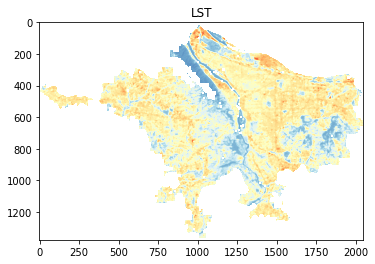

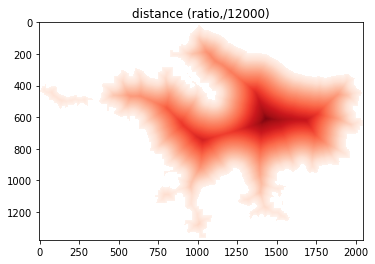

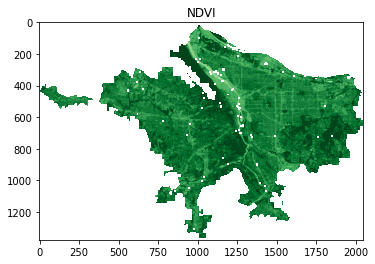

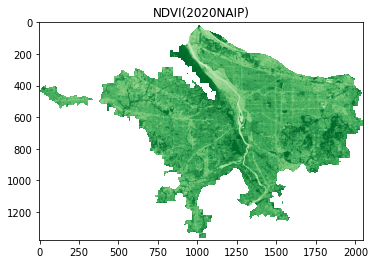

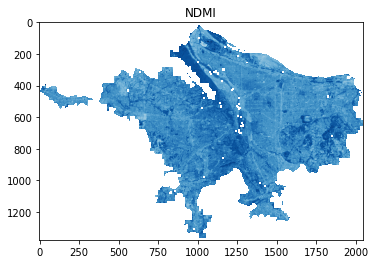

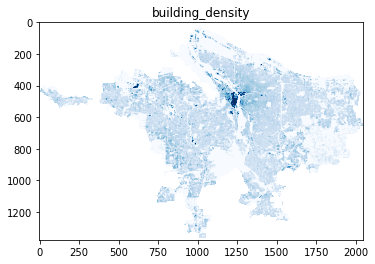

NameError: ignored

In [ ]:
# Visualize loaded images
import matplotlib.pyplot as plt

# lst,distance,ndvi,gndvi,evi,savi,unmixingVeg,ndmi,mndwi,tasseledGreenness

plt.imshow(lst, cmap=plt.cm.get_cmap('RdYlBu').reversed())
plt.title("LST")
plt.show()

plt.imshow(distance, cmap='Reds', vmin=0, vmax=1)
plt.title("distance (ratio,/12000)")
plt.show()

plt.imshow(ndvi, cmap='Greens', vmin=-0.8, vmax=0.8)
plt.title("NDVI")
plt.show()



plt.imshow(naip_ndvi, cmap='Greens', vmin=-0.8, vmax=0.8)
plt.title("NDVI(2020NAIP)")
plt.show()


plt.imshow(ndmi, cmap='Blues', vmin=-0.6, vmax=0.6)
plt.title("NDMI")
plt.show()

plt.imshow(building_density, cmap='Blues', vmin=1, vmax=50)
plt.title("building_density")
plt.show()

plt.imshow(vegUnmix, cmap='Greens', vmin=-0.2, vmax=1)
plt.title("Veg (Spectural Unmix)")
plt.show()

plt.imshow(mndwi, cmap='Blues', vmin=-0.6, vmax=0.6)
plt.title("MNDWI")
plt.show()

plt.imshow(tasseledGreenness, cmap='Greens', vmin=-0.2, vmax=0.4)
plt.title("tasseled_cap_greenness")
plt.show()



# plt.imshow(gndvi, cmap='Greens', vmin=-0.8, vmax=0.8)
# plt.title("GNDVI")
# plt.show()

# plt.imshow(evi, cmap='Greens', vmin=-0.8, vmax=0.8)
# plt.title("EVI")
# plt.show()

# plt.imshow(savi, cmap='Greens', vmin=-0.8, vmax=0.8)
# plt.title("SAVI")
# plt.show()


# plt.imshow(svi, cmap=plt.cm.get_cmap('RdBu').reversed())
# plt.title("SVI")
# plt.show()


In [ ]:
# # Read Metadata
# print(shp_meta)
# print(img_meta)
# print(svi_meta)

In [ ]:
# # Change census tract projection to UTM
# shpfile = shpfile.to_crs(32610) 
# Masking function (By census tract)

# Correlation coefficient function

# Loop over census tracts + append & Save

# print("LST:", lst.shape)
# print("NDVI:", ndvi.shape)
# print("SVI:", svi.shape)

# Sampling

Currently just looping through the sizes of the image array's rows and columns to find a random integer number. For more sophisticated sampling methods, you can use different packages or consider sampling from x,y (row,column) directly to find more combinations. Alternatively, you may want to focus only on points that do not have NaN values and sample from those values.

In [ ]:
import random
n_sample = 1300

In [ ]:
# Sample coordinates from CRS
left, bottom, right, top = rasterio.open(shp_path).bounds
print(left, bottom, right, top)

x_list = range(int(left), int(right))
y_list = range(int(bottom), int(top))


488010.0 5014230.0 549450.0 5055510.0


In [ ]:
# Sample row - column from image array
print(lst.shape)

x_list = range(int(0), int(lst.shape[0]))
y_list = range(int(0), int(lst.shape[1]))

(1376, 2048)


In [ ]:
# Create random samples (pixels)

x_sample = random.sample(x_list, n_sample)
y_sample = random.sample(y_list, n_sample)

coords = list(zip(x_sample,y_sample))

In [ ]:
# Remove duplicates
coords = [*set(coords)]

len(coords) # Size

1300

In [ ]:
# Sampling
ndvi_samples, lst_samples = [],[] #Create empty lists to input results

# Loop through list of coordinates
for r, c in coords:
  ndvi_samples.append(ndvi[r,c]) # Find pixel sample for each image and append into empty list
  lst_samples.append(lst[r,c])


Text(0.5, 1.0, 'Building Density')

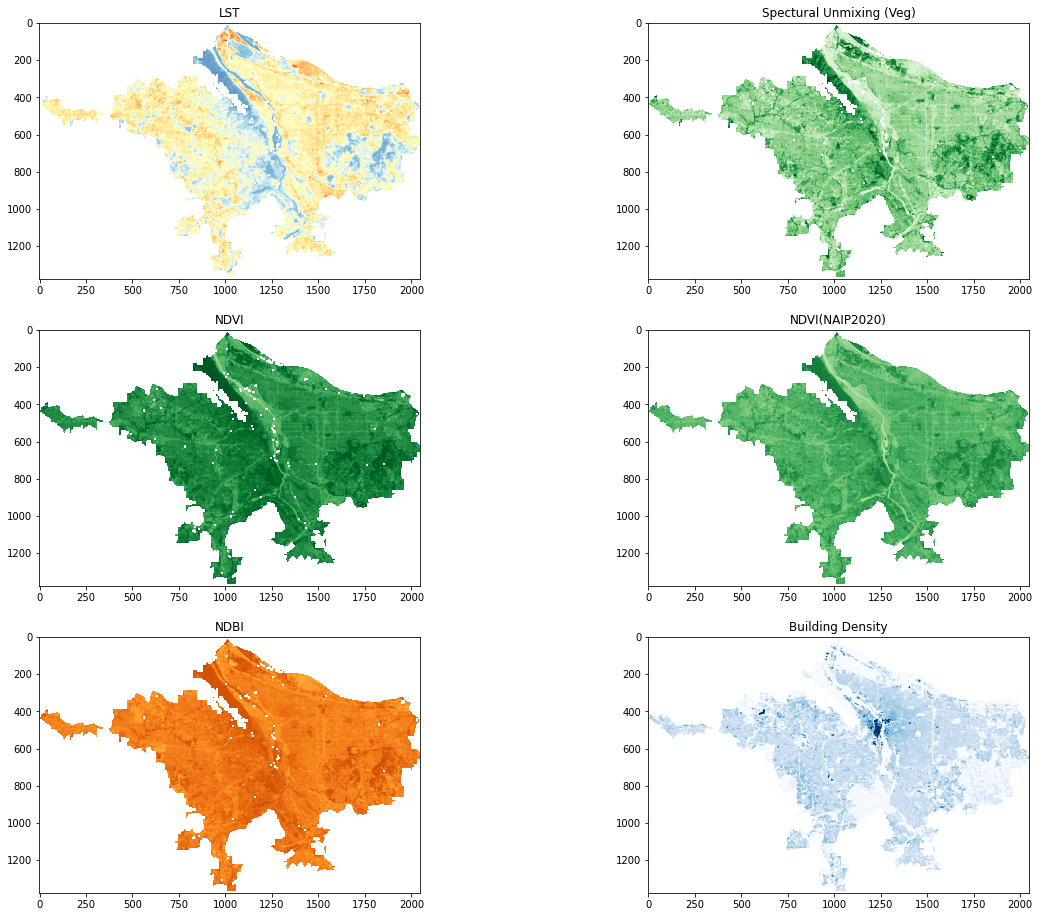

In [ ]:
# # Calculate different spectral indices (except ndvi) from custom function above with landsat 8
# _, savi, msavi, evi, gndvi, vari, gci = spectral_index(b2, b3, b4, b5)


# Visualize
fig, ax = plt.subplots(3,2, figsize=(20,16))

ax[0,0].imshow(lst, cmap=plt.cm.get_cmap('RdYlBu').reversed())
ax[0,0].set_title('LST')

# ax[0,1].imshow(svi, cmap=plt.cm.get_cmap('RdBu').reversed())
# ax[0,1].set_title('SVI')
ax[0,1].imshow(unmixingVeg, cmap='Greens', vmin = -0.2, vmax =1)
ax[0,1].set_title('Spectral Unmixing (Veg)')

ax[1,0].imshow(ndvi, cmap='Greens', vmin = -1, vmax =1)
ax[1,0].set_title('NDVI')

ax[1,1].imshow(naip_ndvi, cmap='Greens', vmin = -1, vmax =1)
ax[1,1].set_title('NDVI(NAIP2020)')

ax[2,0].imshow(ndmi, cmap='YlOrBr', vmin = -1, vmax =1)
ax[2,0].set_title('NDBI')

ax[2,1].imshow(building_density, cmap='Blues', vmin = 0, vmax =50)
ax[2,1].set_title('Building Density')



In [ ]:
# # Sample through all the featuers

# # Add lists to sampling features
# lst_list, svi_list = [],[]
# ndvi_list, gndvi_list, evi_list, savi_list= [],[],[],[]

# # Loop through list of coordinates
# for r, c in coords:
#   lst_list.append(lst[r,c]) # Find pixel sample for each image and append into empty list
#   svi_list.append(svi[r,c])
#   ndvi_list.append(ndvi[r,c])
#   gndvi_list.append(gndvi[r,c])
#   evi_list.append(evi[r,c])
#   savi_list.append(savi[r,c])

# final_df = pd.DataFrame({"LST":lst_list,
#                          "SVI":svi_list,
#                          "NDVI":ndvi_list,
#                          "GNDVI":gndvi_list,
#                          "EVI":evi_list,
#                          "SAVI":savi_list,})

# # Drop NaN values
# final_df = final_df.dropna()

# final_df

In [ ]:
# Obviously this might be a little annoying and repetitive to do everything you have new features. You can then make this into a function
# This will compute the same thing as the sampling code above
# lst,distance,ndvi,gndvi,evi,savi,unmixingVeg,ndmi,mndwi,tasseledGreenness

def pt_samples(img, samples):
  
  sample_list = []
  
  for r,c in samples:
    sample_list.append(img[r,c])

  return sample_list

#####

# Create list of features
feature_list = [lst, ndvi, ndvi_s, naip_ndvi, ndmi, tasseledGreenness, unmixingVeg]
result_array = np.zeros(( len(coords), len(feature_list) )) # Create empty array to store results for each feature

# Loop throuhg features and find results
for i, feature in enumerate(feature_list):
  result_array[:, i] = pt_samples(feature, coords) # Store the sampled pixel from [r,c] into the result_array at index "i"

result_array = pd.DataFrame(result_array)
result_array.columns = ["LST",'NDVI','NDVI(Smoothed)','NDVI(NAIP)','NDMI',"Tasselecd Cap Greenness",'Spectral Unmixing Vegetation' ]

result_array

LST      NDVI  NDVI(Smoothed)  NDVI(NAIP)      NDMI  \
0            NaN       NaN             NaN         NaN       NaN   
1            NaN       NaN             NaN         NaN       NaN   
2            NaN       NaN             NaN         NaN       NaN   
3     314.989777  0.361166        0.338951   -0.106977  0.121777   
4            NaN       NaN             NaN         NaN       NaN   
...          ...       ...             ...         ...       ...   
1295  317.558136  0.062386        0.078203   -0.008969  0.019266   
1296         NaN       NaN             NaN         NaN       NaN   
1297  313.115662  0.332845        0.300567   -0.021834  0.069024   
1298         NaN       NaN             NaN         NaN       NaN   
1299         NaN       NaN             NaN         NaN       NaN   

      Tasselecd Cap Greenness  Spectural Unmixing Vegetation  
0                         NaN                            NaN  
1                         NaN                            NaN  
2                         NaN                            NaN  
3                    0.042282                       0.161425  
4                         NaN                            NaN  
...                       ...                            ...  
1295                -0.085602                       0.255835  
1296                      NaN                            NaN  
1297                 0.032723                       0.138877  
1298                      NaN                            NaN  
1299                      NaN                            NaN  

[1300 rows x 7 columns]

In [ ]:
# Create point geometries from sampled points to generate geo-dataframe
coords_list=[]
with rasterio.open(shp_path) as src:
  for i in range(len(coords)):
    lons, lats = rasterio.transform.xy(src.transform, coords[i][0], coords[i][1])
    coords_list.append([lats,lons])


c = [shapely.geometry.Point(coord[1], coord[0]) for coord in coords_list] #lat, lon order
gdf = gpd.GeoDataFrame(result_array, crs={'init':'EPSG:32610'}, geometry=c)

gdf = gdf.dropna()
gdf

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


LST      NDVI  NDVI(Smoothed)  NDVI(NAIP)      NDMI  \
3     314.989777  0.361166        0.338951   -0.106977  0.121777   
6     303.777893  0.674296        0.720814    0.564815  0.197159   
8     311.844574  0.630559        0.584776    0.146199  0.219069   
9     312.410278  0.589314        0.545692    0.046154  0.269900   
10    313.331635  0.496325        0.490239    0.297297  0.192119   
...          ...       ...             ...         ...       ...   
1287  307.859253  0.684147        0.608531    0.502890  0.357307   
1289  308.150574  0.591742        0.238823    0.301435  0.158816   
1291  314.688843  0.165818        0.432260   -0.094556  0.052445   
1295  317.558136  0.062386        0.078203   -0.008969  0.019266   
1297  313.115662  0.332845        0.300567   -0.021834  0.069024   

      Tasselecd Cap Greenness  Spectural Unmixing Vegetation  \
3                    0.042282                       0.161425   
6                    0.165914                       0.539826   
8                    0.138348                       0.448846   
9                    0.109238                       0.397946   
10                   0.082899                       0.298941   
...                       ...                            ...   
1287                 0.110932                       0.398016   
1289                 0.136031                       0.431425   
1291                -0.003942                       0.086040   
1295                -0.085602                       0.255835   
1297                 0.032723                       0.138877   

                            geometry  
3     POINT (518565.000 5020245.000)  
6     POINT (520305.000 5040585.000)  
8     POINT (488865.000 5042085.000)  
9     POINT (529185.000 5033085.000)  
10    POINT (531855.000 5036595.000)  
...                              ...  
1287  POINT (518085.000 5038455.000)  
1289  POINT (497295.000 5039115.000)  
1291  POINT (528585.000 5032965.000)  
1295  POINT (532365.000 5046855.000)  
1297  POINT (524865.000 5045025.000)  

[530 rows x 8 columns]

In [ ]:
result_array = result_array.dropna()
print (result_array.corr())

                                    LST      NDVI  NDVI(Smoothed)  NDVI(NAIP)  \
LST                            1.000000 -0.713284       -0.769882   -0.580302   
NDVI                          -0.713284  1.000000        0.861565    0.638013   
NDVI(Smoothed)                -0.769882  0.861565        1.000000    0.717909   
NDVI(NAIP)                    -0.580302  0.638013        0.717909    1.000000   
NDMI                          -0.745137  0.829109        0.720051    0.547215   
Tasselecd Cap Greenness       -0.694895  0.929733        0.793032    0.621819   
Spectural Unmixing Vegetation -0.706088  0.880335        0.746631    0.617027   

                                   NDMI  Tasselecd Cap Greenness  \
LST                           -0.745137                -0.694895   
NDVI                           0.829109                 0.929733   
NDVI(Smoothed)                 0.720051                 0.793032   
NDVI(NAIP)                     0.547215                 0.621819   
NDMI       

Visualize geodataframe

In [ ]:
from rasterio.plot import show


src = rasterio.open(img_path)

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
# ax = rasterio.plot.show(src.read(1), extent=extent, ax=ax, cmap='Spectral_r')


Text(86.375, 0.5, 'Latitude')

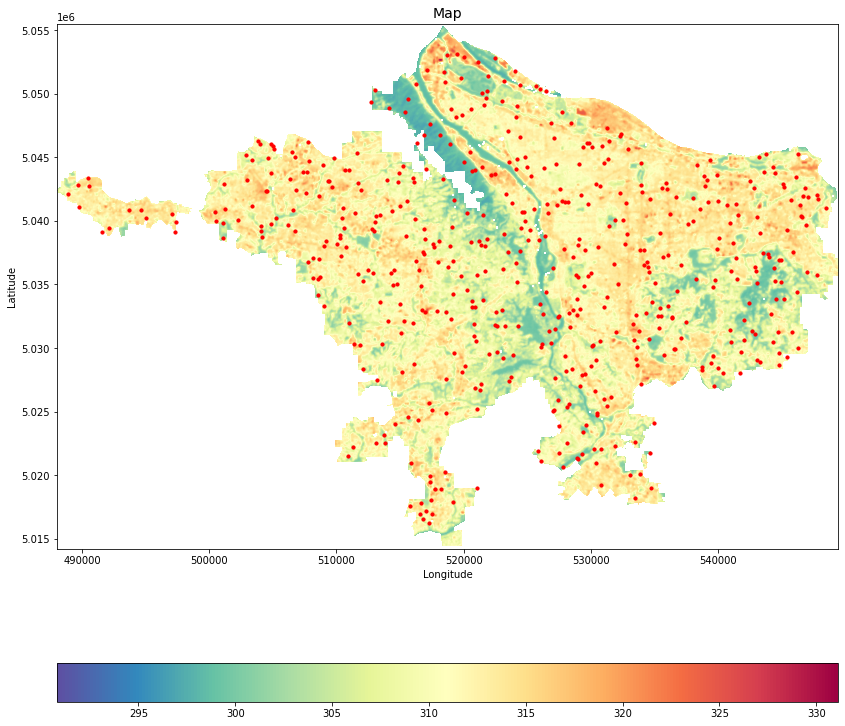

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,14))
gdf.plot(ax=ax, color='red',markersize = 10, marker='o',
        legend = True, legend_kwds={'label':'Sampled Points','shrink': 0.3})

ax = rasterio.plot.show(src.read(1), extent=extent, ax=ax, cmap='Spectral_r')
im = ax.get_images()[0]
fig.colorbar(im, ax=ax,orientation = 'horizontal')

ax.set_title('Map', fontsize=14)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

Visualize some results

In [ ]:
# Create a "DataFrame" which allows for easy visualization (This is an optional step since you can also visualize using the matplotlib package using numpy arrays)
# df = pd.DataFrame({'x':ndvi_samples, 'y':lst_samples}) # Feel free to change this if you want to add more features

In [ ]:
result_array.keys()

Index(['LST', 'NDVI', 'NDVI(Smoothed)', 'NDVI(NAIP)', 'NDMI',
       'Tasselecd Cap Greenness', 'Spectural Unmixing Vegetation', 'geometry'],
      dtype='object')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


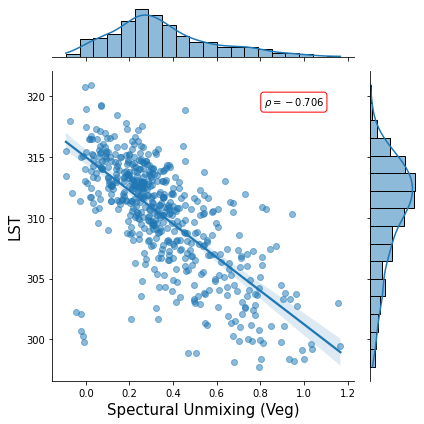

In [ ]:
import seaborn as sns
import scipy
from matplotlib.colors import ListedColormap as cm
x=result_array['Spectral Unmixing Vegetation']
y=result_array['LST']

g = sns.jointplot(x, y, 
                  kind='reg', 
                  palette='magma',
                  joint_kws = {'scatter_kws':dict(alpha=0.5)})

r, p = scipy.stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}$',
                    xy=(0.9, 0.9), xycoords='axes fraction',
                    ha='right', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'red'})

g.set_axis_labels(xlabel='Spectural Unmixing (Veg)', ylabel='LST', size=15)
plt.tight_layout()
plt.show()


# # Plot joint scatter
# g = sns.jointplot(data=result_array, x="Spectural Unmixing (Veg)", y="LST", kind="reg")

# g.map(annotate)
# plt.show()

In [ ]:
p

2.9226814751043188e-33

<Figure size 3600x3600 with 0 Axes>

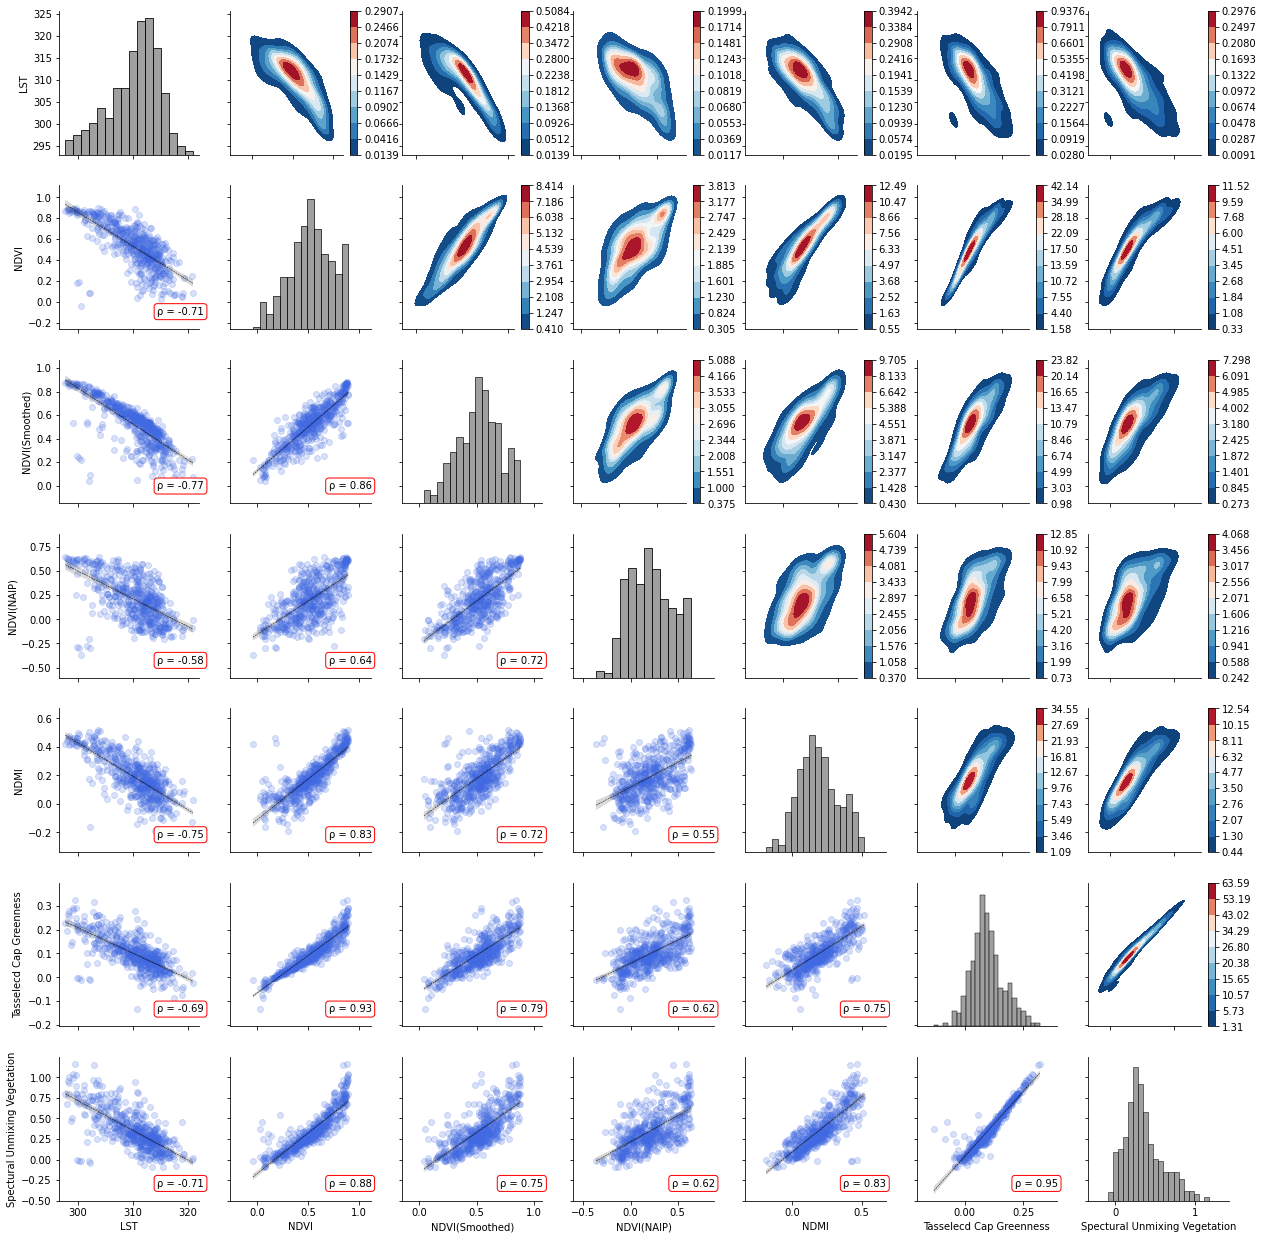

In [ ]:
# Create large scatter plot matrix to compare all the features together
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, .1), xycoords=ax.transAxes,
                bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'red'})


x=result_array['Spectral Unmixing Vegetation']
y=result_array['LST']

# g = sns.pairplot(result_array, kind="reg", plot_kws={'line_kws':{'color':'black', 'linestyle':'--', 'linewidth':0.5}, 'scatter_kws': {'alpha': 0.2}})

plt.figure(figsize=(50,50))
g = sns.PairGrid(result_array)
g.map_upper(sns.kdeplot,fill=True, cmap='RdBu_r', cbar=True, shade=True)
g.map_lower(sns.regplot, color='royalblue', scatter_kws={'alpha':0.2},line_kws={'color':'black', 'linestyle':'--', 'linewidth':0.5})
g.map_diag(sns.histplot, color='grey')
g.map_lower(corrfunc)
plt.show()


In [ ]:
# sns.residplot(data=result_array, x='Spectral Unmixing (Veg)', y="LST")

In [ ]:
# # Plot KDE Plots
# g = sns.PairGrid(result_array)
# g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)



# Clustering with K-Means

In [ ]:
result_array=result_array.drop('geometry',axis=1)

NDVI


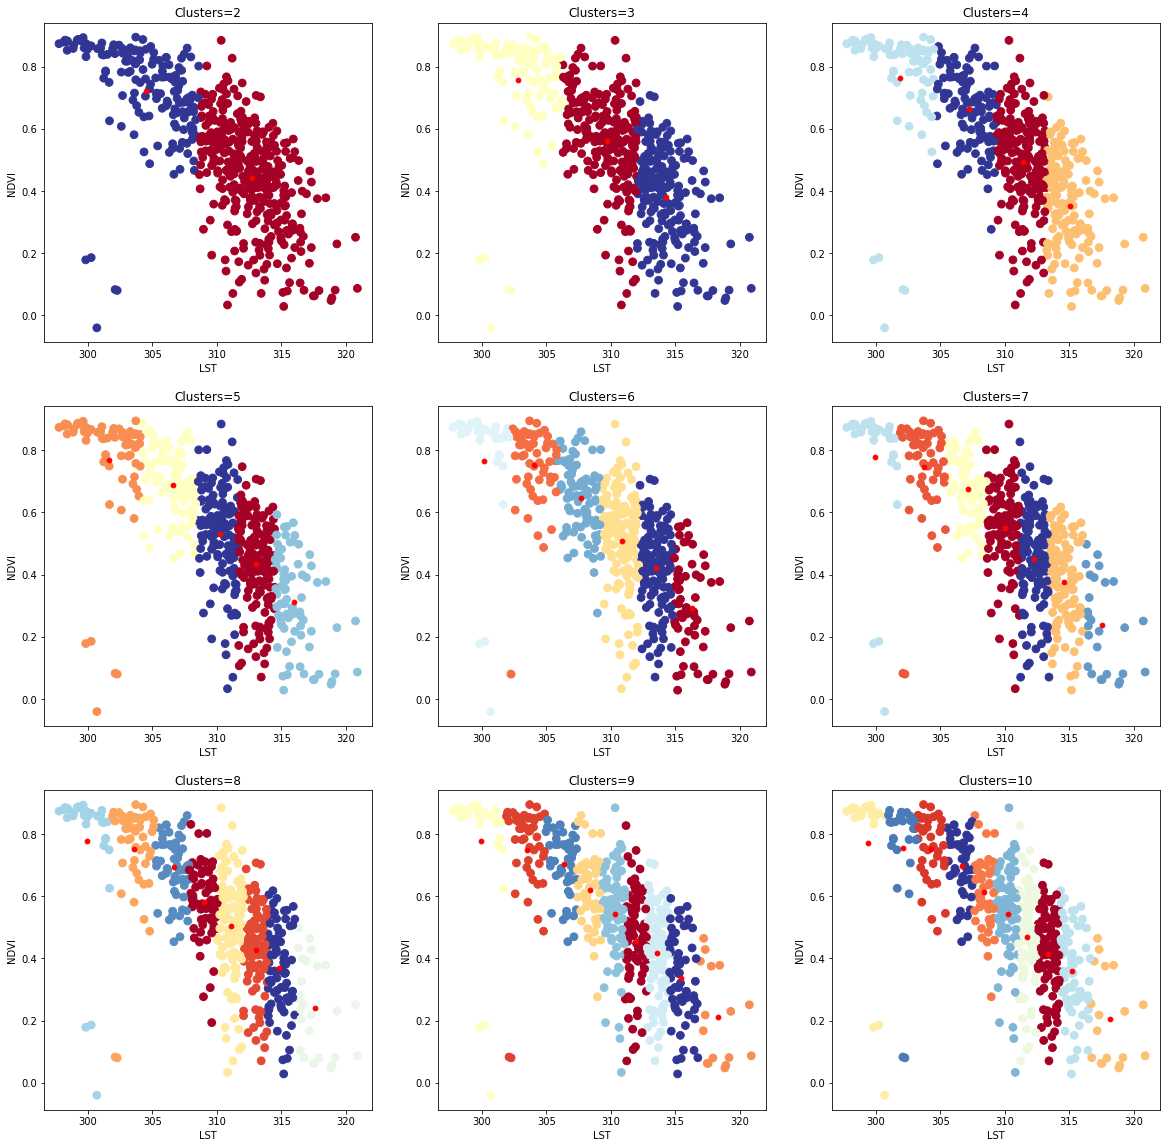

NDVI(Smoothed)


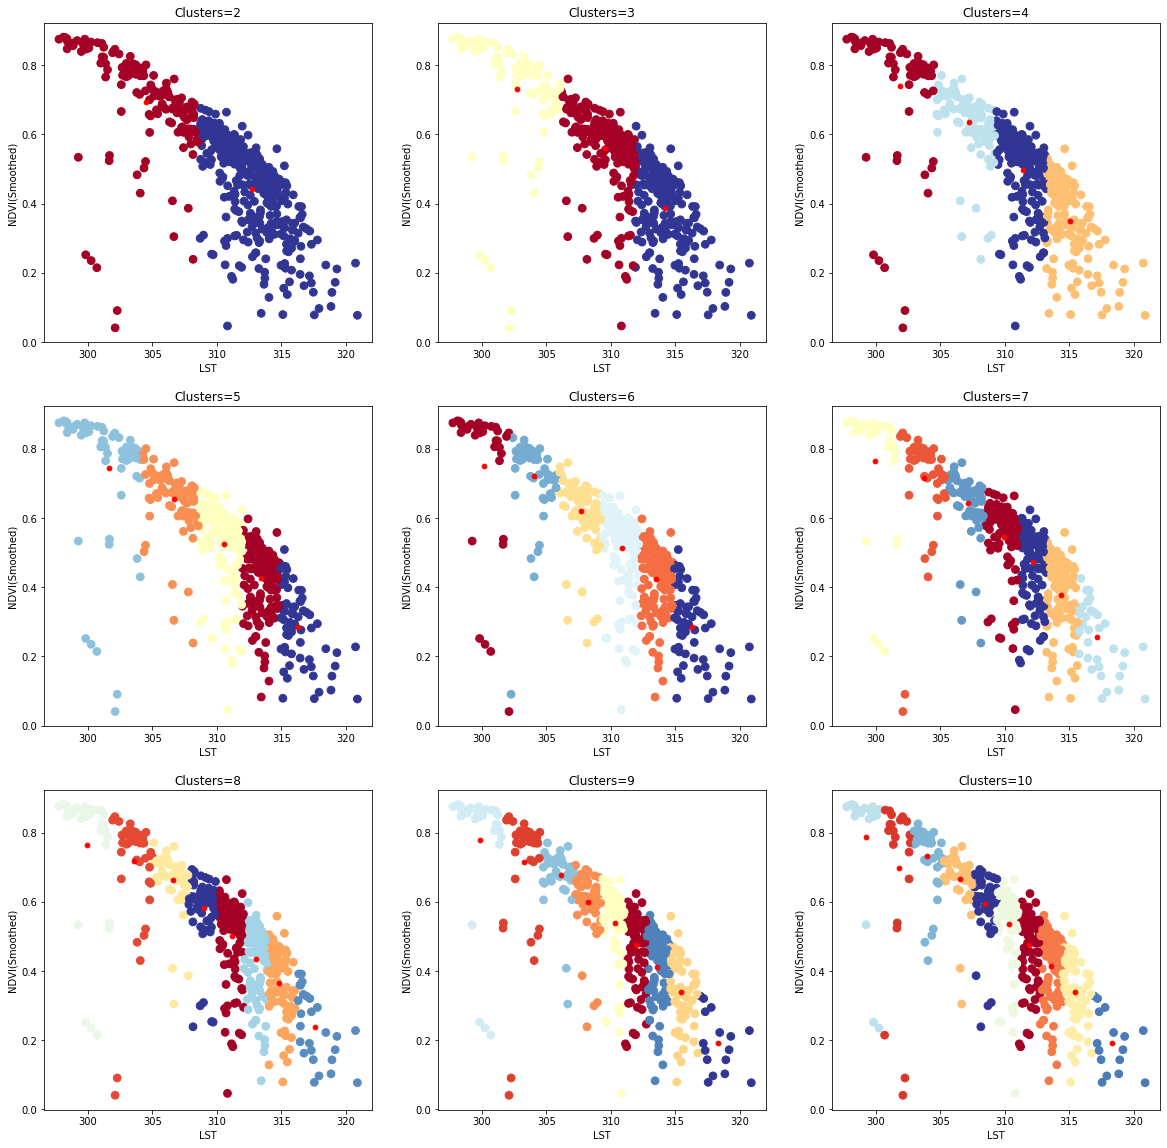

NDVI(NAIP)


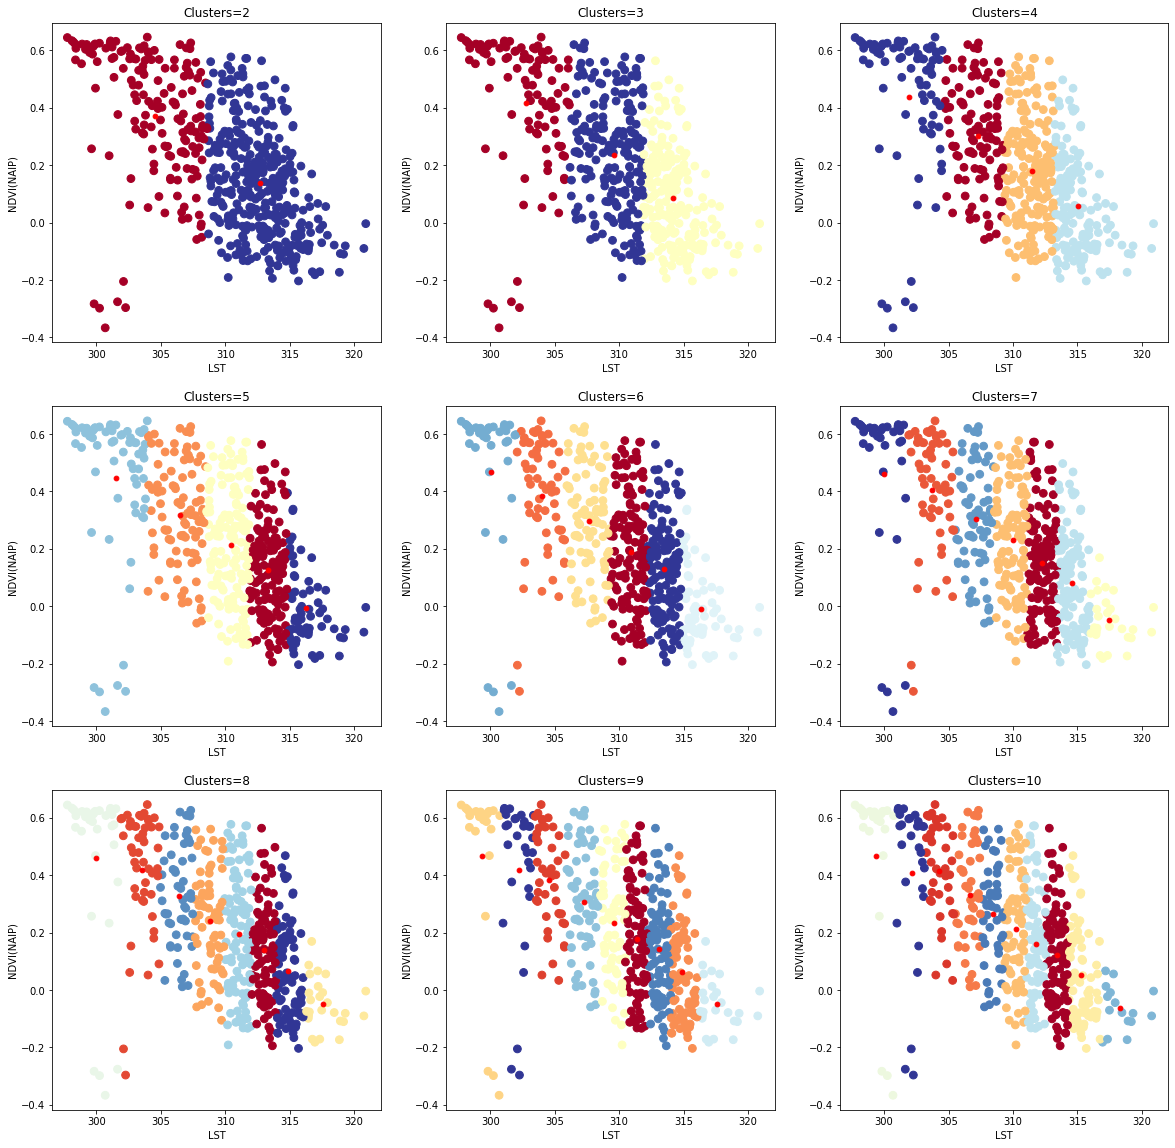

NDMI


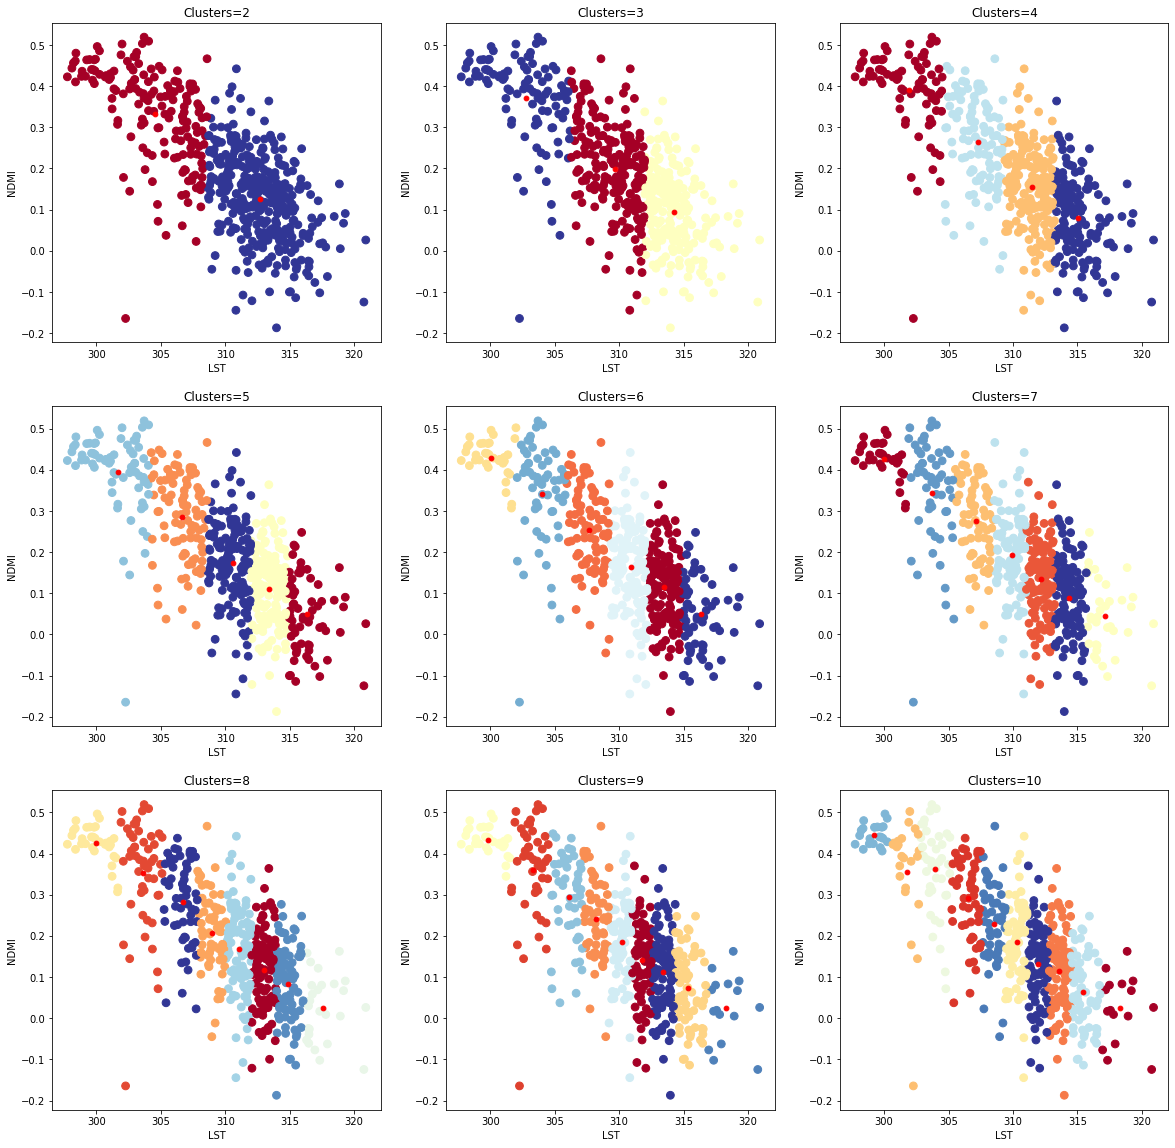

Tasselecd Cap Greenness


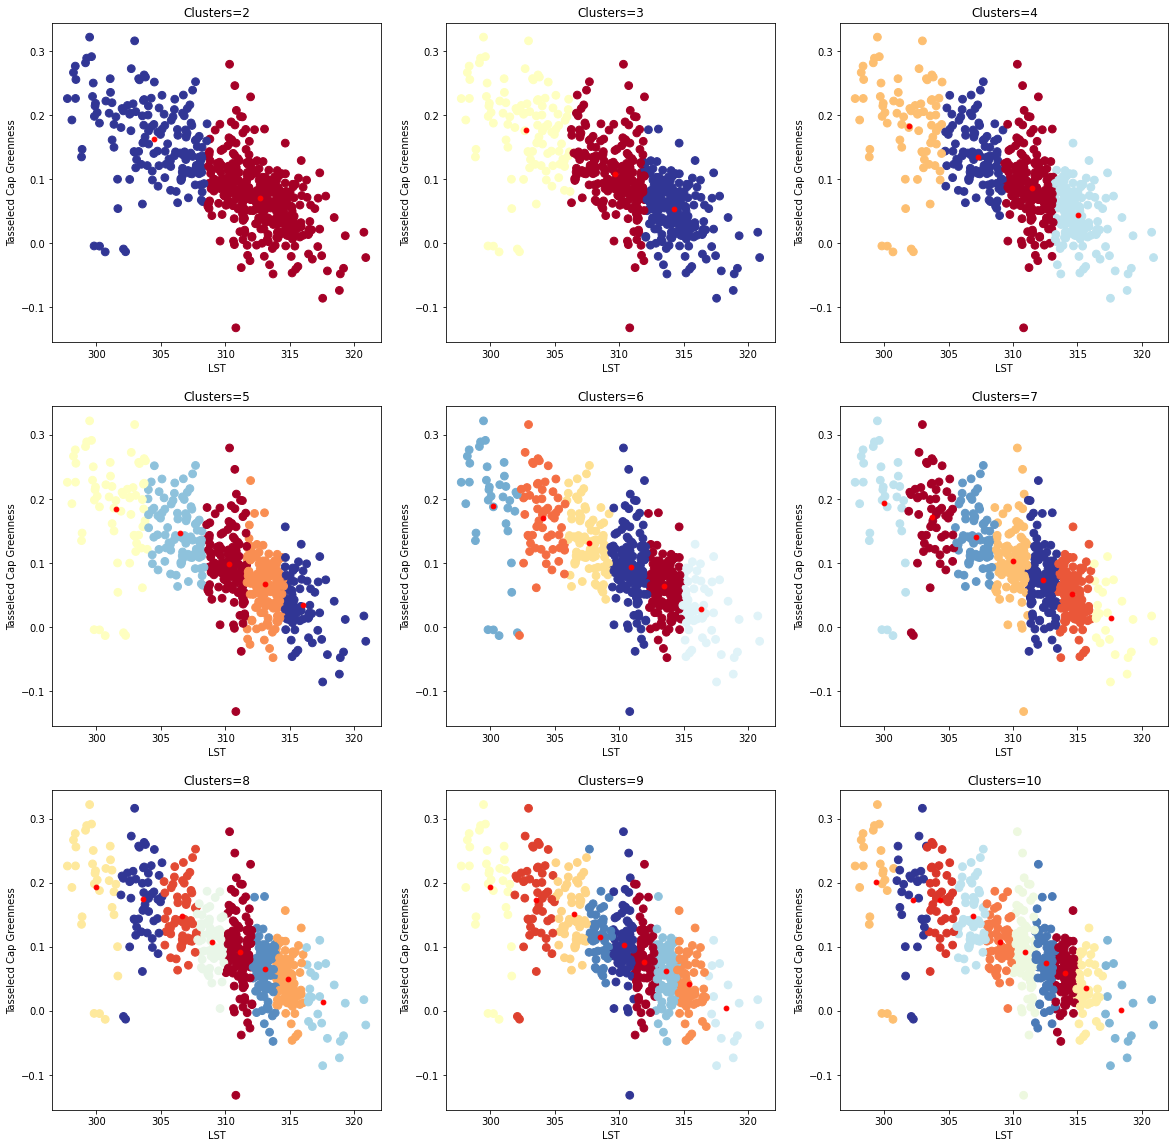

Spectural Unmixing Vegetation


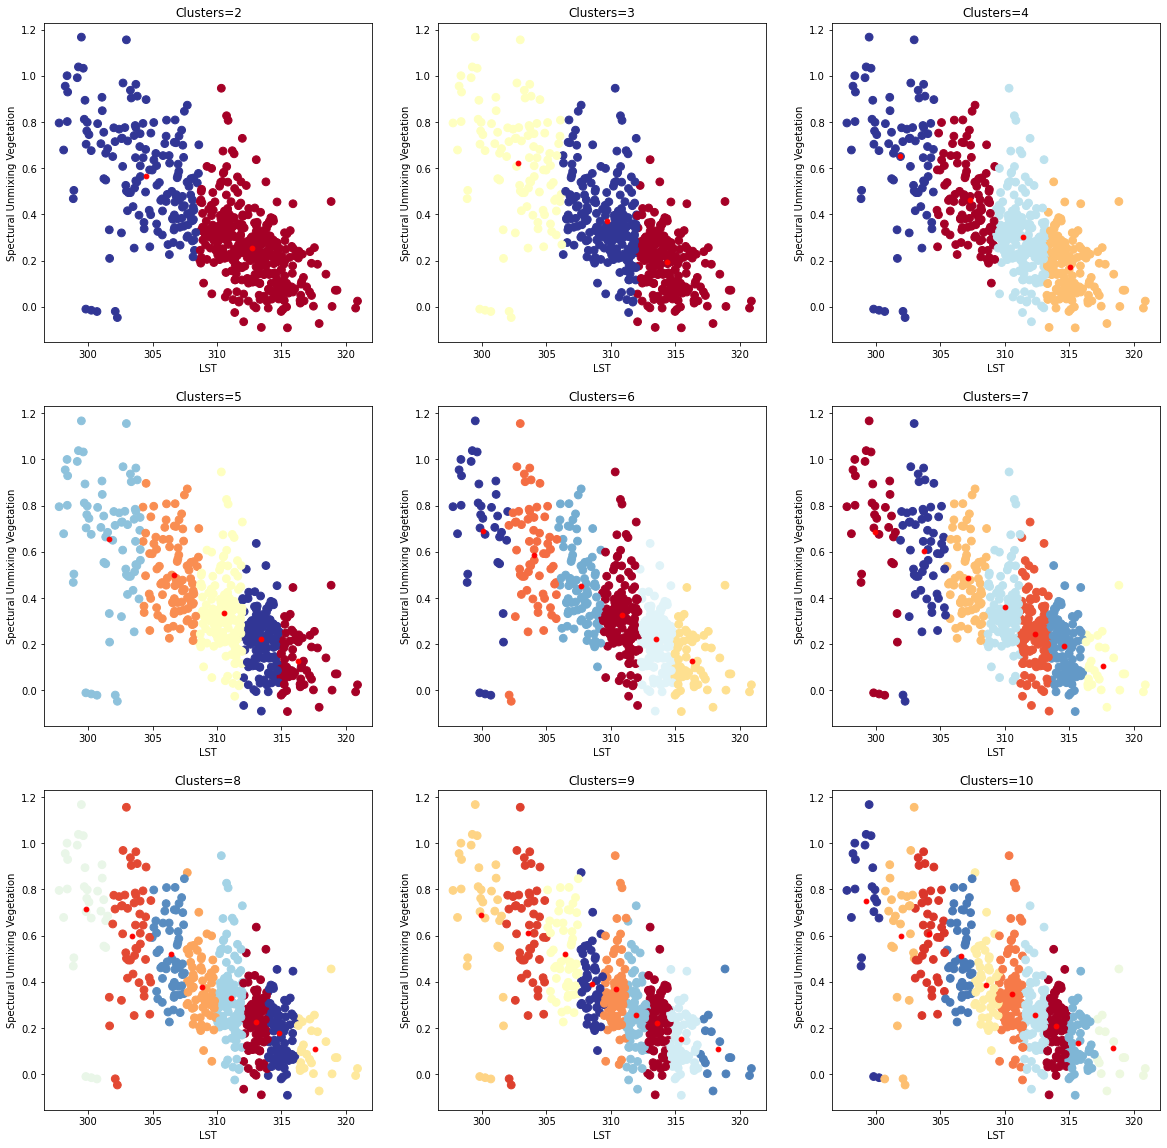

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

def KMeans_clustering(dataset, n):
  clustering_kmeans = KMeans(n_clusters = n,
                             init='k-means++',
                             max_iter=300,
                             algorithm='elkan')
  clustering_kmeans.fit(dataset)

  centroids = clustering_kmeans.cluster_centers_
  centroids_df = pd.DataFrame(centroids, columns=['X','Y'])

  label = clustering_kmeans.labels_
  # result_array['labels'] = label

  inertia = clustering_kmeans.inertia_
  silhouette = metrics.silhouette_score(dataset,label)

  return inertia, label, centroids_df, silhouette

def plot_cluster_matrix(X):
  
  inertia_values, silhouette_scores = [],[]

  fig = plt.figure(figsize=(20,20))

  # Loop through clusters 2 - 10
  for i in range(2,11):

    # Kmeans
    X_inertia, X_label, X_centroid, X_silhouette = KMeans_clustering(X.values, i)

    inertia_values.append(X_inertia)
    silhouette_scores.append(X_silhouette)

    # Centroid values
    x_name = str(X.columns[0])
    y_name = str(X.columns[1])
    centroid_df = pd.DataFrame(X_centroid)
    centroid_df.columns = [x_name, y_name]

    # Plot 3x3 
    sub = fig.add_subplot(330+i-1)
    sub.scatter(X.iloc[:,0], X.iloc[:,1], s=60, c=X_label, cmap='RdYlBu')
    sub.scatter(centroid_df.iloc[:,0],centroid_df.iloc[:,1], s=90, marker='.', color='r')
    sub.set_title("Clusters=" + str(i))
    sub.set_xlabel(x_name)
    sub.set_ylabel(y_name)
  
  plt.show()

  return centroid_df

clusters_df = pd.DataFrame()
for factor in result_array.keys()[1:]:
  print(factor)

  cluster_centroids = plot_cluster_matrix(pd.DataFrame(result_array[['LST',factor]]))
  clusters_df = pd.concat((clusters_df, cluster_centroids), axis = 1)


# plt.figure(figsize=(10,6))
# plt.plot(np.arange(2,11), inertia_values)

# plt.figure(figsize=(10,6))
# plt.plot(np.arange(2,11), silhouette_scores)

# Clustering
For more information on clustering features using K-means and silhouette scores, refer to : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.



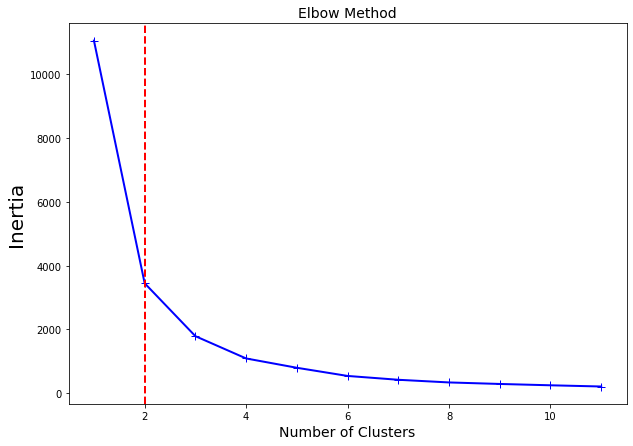

In [ ]:
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

wss = [] # Inertia

K=range(1,12)

for k in K:
    kmeans=KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(result_array)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})

# Using elbow method to select the correct number of clusters
_ = plt.figure(figsize = (10,7))
_ = plt.plot(range(1,12), wss, linewidth = 2, color = 'blue', marker='+', markersize = 8)
_ = plt.title('Elbow Method', fontsize = 14)
_ = plt.xlabel('Number of Clusters',fontsize = 14)
_ = plt.ylabel('Inertia',fontsize = 20)

n_clusters = 2 # Predefined line
_ = plt.axvline(x = n_clusters, linewidth = 2, color = 'red', linestyle = '--')
_ = plt.show()

In [ ]:
# Double-checking the correct number of clusters is chosen using silhouette scores
for i in range(2,13):
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=42).fit(result_array).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(result_array,labels,metric="euclidean",
                                         sample_size=1000,random_state=42)))

Silhouette score for k(clusters) = 2 is 0.6141312886916883
Silhouette score for k(clusters) = 3 is 0.5279369659852415
Silhouette score for k(clusters) = 4 is 0.5118891372317597
Silhouette score for k(clusters) = 5 is 0.4867719560014387
Silhouette score for k(clusters) = 6 is 0.5002970983422204
Silhouette score for k(clusters) = 7 is 0.48590177951635394
Silhouette score for k(clusters) = 8 is 0.4733053550512204
Silhouette score for k(clusters) = 9 is 0.4621218189899337
Silhouette score for k(clusters) = 10 is 0.44456501894635975
Silhouette score for k(clusters) = 11 is 0.4413411220922624
Silhouette score for k(clusters) = 12 is 0.44256831524251117


In [ ]:
# Takes forever to run...
silhouette_score(result_array, kmeans.labels_)

0.44370394383358713

In [ ]:
# Top 10
kmeans_per_k = [cluster.KMeans(n_clusters=k, random_state=42).fit(result_array) for k in range(1,10)]

silhouette_scores = [silhouette_score(result_array, model.labels_)
                    for model in kmeans_per_k[1:]]
silhouette_scores

[0.6141312886916883,
 0.5279369659852415,
 0.5118891372317597,
 0.4867719560014387,
 0.5002970983422205,
 0.4859017795163538,
 0.47330535505122046,
 0.4621218189899337]

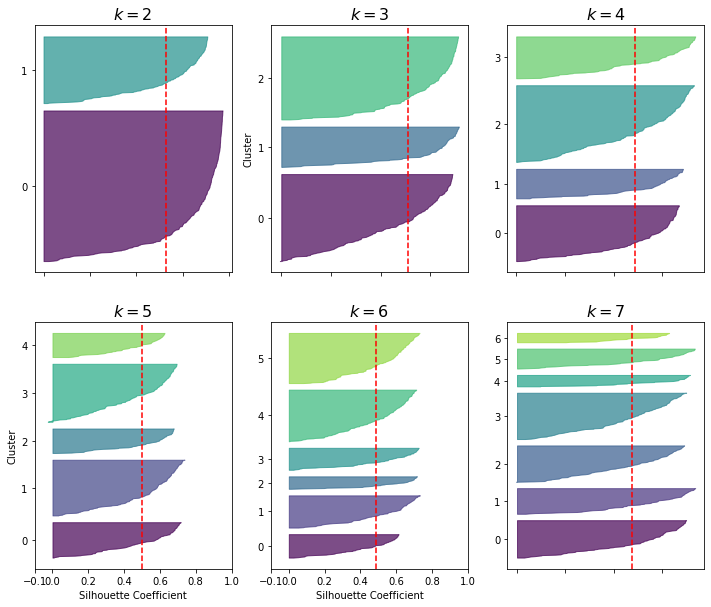

In [ ]:
# Plot silhouettes 
# Best: Silhouettes extend past beyond red line and are similar in thickness

plt.figure(figsize=(12,10))

for k in (2,3,4,5,6,7):
    plt.subplot(2,3,k-1)
    
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(result_array, y_pred)
    
    padding = len(result_array)//30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = matplotlib.cm.viridis(i/k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs)//2)
        pos += len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3,5):
        plt.ylabel('Cluster')
        
    if k in(5,6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Silhouette Coefficient')
        
    else:
        plt.tick_params(labelbottom=False)
        
    plt.axvline(x=silhouette_scores[k-1], color='red', linestyle='--')
    plt.title('$k={}$'.format(k), fontsize=16)
    
plt.show()

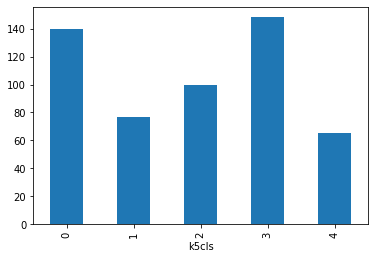

In [ ]:
# Plot size of clusters
kmeans = KMeans(n_clusters=5) # 5 clusters found to be "optimal" from above --> Feel free to change
k5cls = kmeans.fit(result_array)

result_array['k5cls'] = k5cls.labels_

k5sizes = result_array.groupby('k5cls').size()

_ = k5sizes.plot.bar()

In [ ]:
result_array.keys()[:-1]

Index(['LST', 'NDVI', 'NDVI(Smoothed)', 'NDVI(NAIP)', 'NDMI',
       'Tasselecd Cap Greenness', 'Spectural Unmixing Vegetation'],
      dtype='object')

In [ ]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
feature_names = result_array.keys()[:-1]

k5means = result_array.groupby('k5cls')[feature_names].mean()
k5means.T.round(3)

k5cls                                0        1        2        3        4
LST                            313.462  301.901  307.121  310.780  316.311
NDVI                             0.422    0.765    0.669    0.512    0.291
NDVI(Smoothed)                   0.425    0.741    0.641    0.516    0.285
NDVI(NAIP)                       0.131    0.438    0.311    0.190   -0.010
NDMI                             0.114    0.390    0.269    0.165    0.050
Tasselecd Cap Greenness          0.064    0.184    0.138    0.094    0.028
Spectural Unmixing Vegetation    0.223    0.651    0.473    0.326    0.129

In [ ]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary

k5desc = result_array.groupby('k5cls')[feature_names].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
                               count        mean       std         min  \
LST                            140.0  313.462274  0.739203  312.159485   
NDVI                           140.0    0.422010  0.128243    0.070395   
NDVI(Smoothed)                 140.0    0.425445  0.097934    0.082781   
NDVI(NAIP)                     140.0    0.131164  0.163227   -0.194313   
NDMI                           140.0    0.114413  0.090688   -0.187221   
Tasselecd Cap Greenness        140.0    0.063837  0.036776   -0.047722   
Spectural Unmixing Vegetation  140.0    0.222527  0.114581   -0.089632   

                                      25%         50%         75%         max  
LST                            312.887695  313.379578  314.063522  314.823486  
NDVI                             0.348932    0.430952    0.506158    0.707369  
NDVI(Smoothed)                   0.359053    0.451122    0.498972    0.597568  
NDVI(NAIP)                       0.003425    0.138842    0.22327

In [ ]:
# Index db on cluster ID
tidy_db = result_array.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[feature_names]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

k5cls       Attribute      Values
0      4             LST  314.989777
1      4            NDVI    0.361166
2      4  NDVI(Smoothed)    0.338951
3      4      NDVI(NAIP)   -0.106977
4      4            NDMI    0.121777

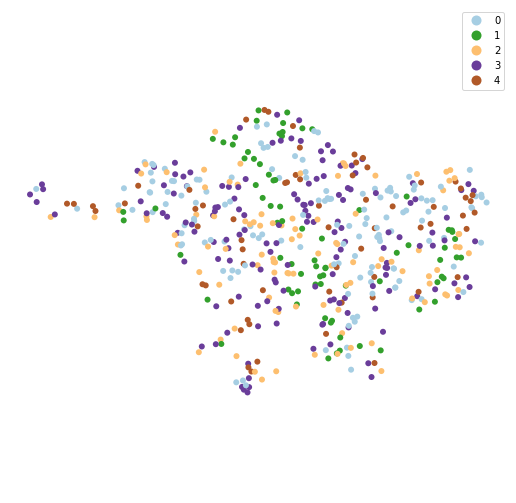

In [ ]:
# Assign labels into a column
gdf['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='k5cls', categorical=True, legend=True, cmap='Paired',linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
# plt.title(r'Clusters (k-means, $k=5$)')
# Display the map
plt.show()

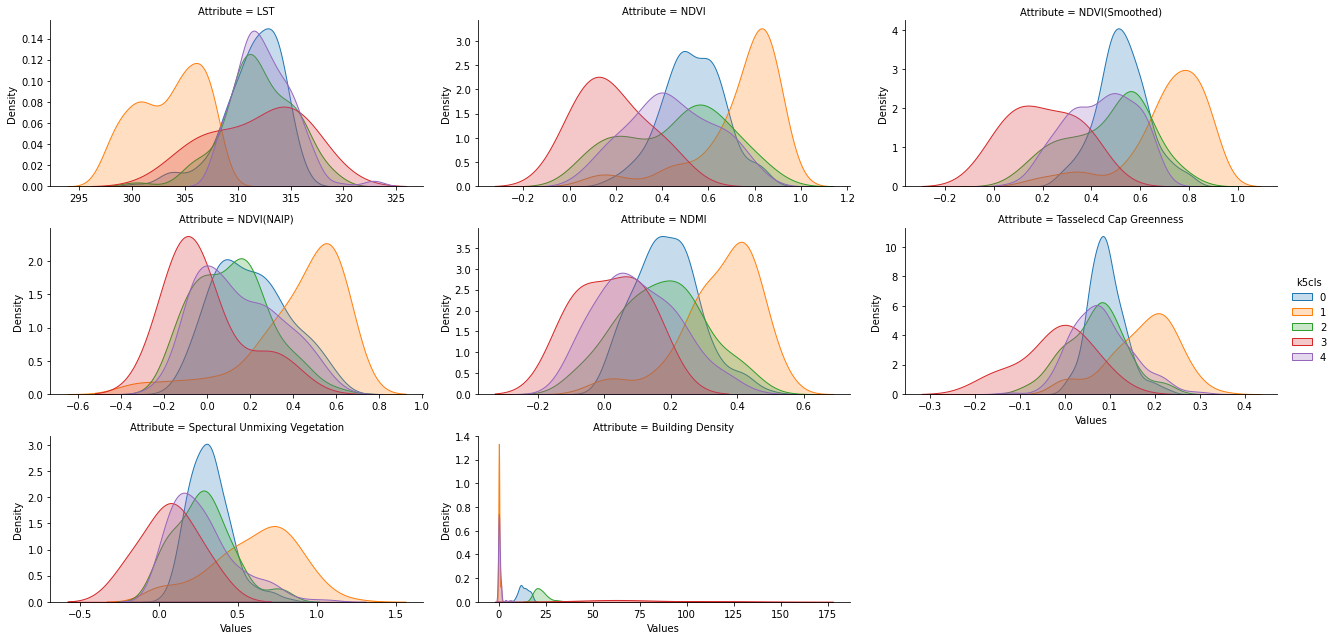

In [ ]:
# Setup the facets
facets = sns.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

#More plotting and visualizations!

In [ ]:
plt.figure(figsize=(15,12))
plt.scatter(ndvi_img, lst_img, alpha = 0.3)

plt.show()

NameError: ignored

<Figure size 1080x864 with 0 Axes>

In [ ]:
ndvi_thres = ndvi_img
ndvi_thres[ndvi_thres<0]=np.nan
fig,ax = plt.subplots(1, figsize=(8,5) )

# Plot Red vs Green
ax.set_title('NDVI thresholded')
ax.scatter(ndvi_img, lst_img,alpha=0.3,s=1,c=ndvi_img, cmap='jet')
ax.set_xlabel('NDVI')
ax.set_ylabel('LST')

NameError: ignored

In [ ]:
# KDE Plot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


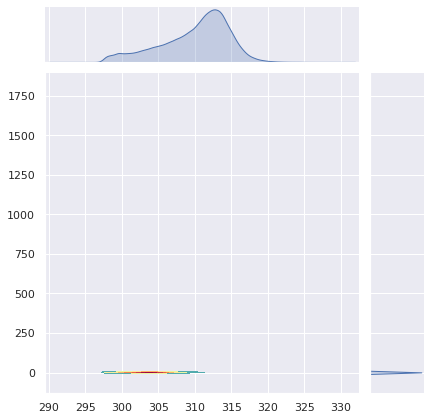

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# make jointplot with linearised images:
sns.jointplot(lst.ravel(), ndvi.ravel(), cmap='Spectral_r',kind='kde', fill=True)


In [ ]:
# Clustering (K-means, PCA)

# Sampling

In [ ]:
img_files

['/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/LST.tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/NDVI.tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190501ImageStack.tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190501TractStack.tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190602ImageStack.tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190720ImageStack.tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,EVI,SAVI)/landsat20190720TractStack (1).tif',
 '/content/drive/My Drive/XihanYAO_GISDataShare/230102_MacroCityScaleAnalysis(LST,NDVI,GNDVI,E

In [ ]:
naip_img = rasterio.open(img_files[0])

In [ ]:
east_labels = east_labels.to_crs(6557) # Name: NAD83(2011) / Oregon GIC Lambert (ft)
coords = list(zip(east_labels.geometry.x, east_labels.geometry.y))

east_labels['raster'] = [x for x in naip_img.sample(coords)]

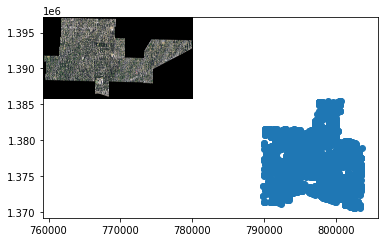

In [ ]:
from rasterio.plot import show
src = rasterio.open(img_files[0])


fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')

east_labels.plot(ax=ax)


In [ ]:
src = rasterio.open(img_files[0])

coord_list = [(x,y) for x,y in zip(east_labels['geometry'].y , east_labels['geometry'].x)]
east_labels['value'] = [x for x in src.sample(coord_list)]

In [ ]:
east_labels['value']

0       [0, 0, 0, 0]
1       [0, 0, 0, 0]
2       [0, 0, 0, 0]
3       [0, 0, 0, 0]
4       [0, 0, 0, 0]
            ...     
5817    [0, 0, 0, 0]
5818    [0, 0, 0, 0]
5819    [0, 0, 0, 0]
5820    [0, 0, 0, 0]
5821    [0, 0, 0, 0]
Name: value, Length: 5822, dtype: object

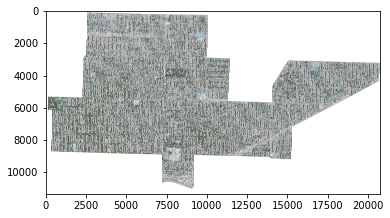

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(naip_img[0])

In [ ]:
[x for x in naip_img.sample(coords)]

[array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0],

In [ ]:
# Read points from shapefile

# Open the raster and store metadata
naip_img

# Sample the raster at every point location and store values in DataFrame
pts['Raster Value'] = [x for x in src.sample(coords)]
pts['Raster Value'] = probes.apply(lambda x: x['Raster Value'][0], axis=1)

NameError: ignored

In [ ]:
# Sampling method
# (1) Random Sampling
if sampling_method == 1:
    
    # Create full training dataset
    # Ensure sample is from a finite pixel
    rand_num = 10000

    aa = np.argwhere((np.isfinite(dsm_img)) | (np.isfinite(ps_img[:,:,0])) | (np.isfinite(ps_img[:,:,1])) | (np.isfinite(ps_img[:,:,2])) | (np.isfinite(ps_img[:,:,3])))

    training_pt_df = pd.DataFrame(aa)
    training_pt_df.columns = ['x','y']

    # Create sample dataset : (1) Fixed number at random (2) Percentage
    training_pt_sampled = training_pt_df.sample(rand_num).reset_index() # 1

    
# (2) Relative Frequency Sampling    
elif sampling_method == 2:
    
    # Sample for each class (8 classes)

    for value in np.unique(ref_img[~np.isnan(ref_img)]):    
        tmp_df = pd.DataFrame()

        tmp = np.where(ref_img == value)
        # tmp_col = np.column_stack((tmp[0],tmp[1]))
        tmp_df['x'] = tmp[0]
        tmp_df['y'] = tmp[1]

        tmp = tmp_df.sample(int(rand_num * class_df["Rel Frequency (%)"][int(value-1)])).reset_index() # 1
        tmp["Class"] = np.full(len(tmp), int(value))
        
        print(value)
        if int(value) == 1:
            final_df = pd.DataFrame(tmp)
        else:
            final_df = np.vstack((final_df, tmp))

    # Create training dataset DF        
    training_pt_sampled = pd.DataFrame()        
    training_pt_sampled["Index"] = final_df[:,0]
    training_pt_sampled["x"] = final_df[:,1]
    training_pt_sampled["y"] = final_df[:,2]
    training_pt_sampled["Class"] = final_df[:,3]
    
    
# (3) Fixed Sampling    
elif sampling_method == 3:
    
    # Sample for each class (8 classes)

    for value in np.unique(ref_img[~np.isnan(ref_img)]):    
        tmp_df = pd.DataFrame()

        tmp = np.where(ref_img == value)
        # tmp_col = np.column_stack((tmp[0],tmp[1]))
        tmp_df['x'] = tmp[0]
        tmp_df['y'] = tmp[1]

        tmp = tmp_df.sample(int(rand_num/len(np.unique(ref_img[~np.isnan(ref_img)])))).reset_index() # 1
        tmp["Class"] = np.full(len(tmp), int(value))

        if int(value) == 1:
            final_df = pd.DataFrame(tmp)
        else:
            final_df = np.vstack((final_df, tmp))

    # Create training dataset DF        
    training_pt_sampled = pd.DataFrame()        
    training_pt_sampled["Index"] = final_df[:,0]
    training_pt_sampled["x"] = final_df[:,1]
    training_pt_sampled["y"] = final_df[:,2]
    training_pt_sampled["Class"] = final_df[:,3]

In [ ]:
# Train dataset
trained_stack_list = []

# for i in range(rand_num):
for i in range(len(training_pt_sampled)):
    img_stack[training_pt_sampled.loc[i]['x'], training_pt_sampled.loc[i]['y'],:]
    trained_stack_list.append(img_stack[training_pt_sampled.loc[i]['x'], training_pt_sampled.loc[i]['y'],:])
    
    
# Test dataset
gt_stack_list = []

# for i in range(rand_num):
for i in range(len(training_pt_sampled)):
    ref_img[training_pt_sampled.loc[i]['x'], training_pt_sampled.loc[i]['y']].astype(int)
    gt_stack_list.append(ref_img[training_pt_sampled.loc[i]['x'], training_pt_sampled.loc[i]['y']])

In [ ]:
# Drop NaN values
train_drop = [np.argwhere(np.isnan(trained_stack_list))[i][0] for i in range(len(np.argwhere(np.isnan(trained_stack_list))))]
training_dataset = pd.DataFrame(trained_stack_list)
training_dataset=training_dataset.drop(np.unique(train_drop))

gt_dataset = pd.DataFrame(gt_stack_list)
gt_dataset=gt_dataset.drop(np.unique(train_drop))     
# gtt_dataset = list(map(int, gt_dataset))

In [ ]:
# Holdout sets
from sklearn.model_selection import train_test_split
random_state = 123

# X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))
# print("Validation dataset size: ", len(X_val))

In [ ]:
print("# of NaN in train data :", np.where(np.isnan(training_dataset)))
print("# of NaN in test data :", np.where(np.isnan(gt_dataset)))

# Classification

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

# Prediction